# Report

The goal is to identify which features are important and influence the buying intent of customers. There are 3 sets of feature and 2 models are trained on each set. The tree based model(Gradient boosted trees) will be used to determine feature importance. The model with the highest Balanced accuracy score will be selected. The neural netwrok based mode serves as reference for how good the tree based model is. Ideally the performance between the two models should be equal. 


## Model selection

The hyper parameter for each model is optimized using bayesian optimization and 5 fold  stratified Cross Validation. Each model is trained on there different transformations of the original dataset. Since the data set is imbalanced be use balanced accuracy as the metric.

### Optimization and selection for gradient boosted trees

In [1]:
# imports
import lightgbm as lgb #light gradient boosted tree
from sklearn.model_selection import train_test_split, StratifiedKFold # train and test split
from sklearn.metrics import balanced_accuracy_score,precision_score# metrics
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK# optimization
import numpy as np
import pandas as pd # reading data
import warnings
warnings.simplefilter("ignore")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# read data
df_encoded = pd.read_csv('/Users/nikk/Downloads/IBM Capstone/online_shoppers_intention_encoded.csv', index_col=False)
df_scaled = pd.read_csv('/Users/nikk/Downloads/IBM Capstone/online_shoppers_intention_encoded_scaled.csv', index_col=False)
df_transformed = pd.read_csv('/Users/nikk/Downloads/IBM Capstone/online_shoppers_intention_encoded_scaled_transformed.csv', index_col=False)

In [3]:
#seperate label
label = df_encoded.pop('Revenue').astype('int')
_,_ = df_scaled.pop('Revenue'),df_transformed.pop('Revenue')

In [32]:
#split object for CV 
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
#Hyperparameter search space for gradient boosed trees
lgb_space = {'lr':hp.loguniform('lr',-6.9,-2.3),'num_leaves':hp.quniform('num_leaves',15,255,1),
         'max_depth':hp.choice('max_depth',[-1,9,12]),'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0)}

In [33]:
def lgb_optimizer(params):
    '''A function to optimize  lgb classifier
    :params:=params , dictionary containing the Hyper-parameters for the classifier
    returns true loss and validation loss
    '''
    if 'num_leaves' in params:
        params['num_leaves']=int(params['num_leaves'])
    if 'max_depth' in params:
        params['max_depth']=int(params['max_depth'])
    val_score=[]
    true_scores=[]
    rd=1
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
        clf = lgb.LGBMClassifier(n_estimators=2000,**params)
        clf.fit(X_tr,y_tr,eval_set=(X_val,y_val),early_stopping_rounds =200,eval_metric='logloss',verbose=False)
        y_pred = clf.predict(X_val)
        y_tr_pred=clf.predict(X_tr)
        score=balanced_accuracy_score(y_val,y_pred,)
        true_score=balanced_accuracy_score(y_tr,y_tr_pred)
        val_score.append(score)
        true_scores.append(true_score)
        rd+=1
    mean,std =np.mean(val_score),np.std(val_score)
    true_mean=np.mean(true_scores)
    print("mean: {}, Std: {}".format(mean,std))
    return {'loss':-mean,'status': STATUS_OK,'true_loss':-true_mean}

In [34]:
#split into train and test and call the fmin(optimizer) function for encoded dataset
X_train,X_test,y_train,y_test = train_test_split(df_encoded,label,test_size=0.2,random_state=42)
trials_encoded = Trials()
best_e= fmin(lgb_optimizer,lgb_space, algo=tpe.suggest, max_evals=20, trials=trials_encoded)

mean: 0.7648032999126473, Std: 0.009472252556223595 
mean: 0.765598735570849, Std: 0.019700513434582494                            
mean: 0.7721271727299197, Std: 0.011347568406319257                           
mean: 0.755794242211039, Std: 0.0245689845062744                              
mean: 0.7700370156072898, Std: 0.018229468484128417                           
mean: 0.7690302648203019, Std: 0.017938507025367634                           
mean: 0.7511019453813594, Std: 0.015283663553883664                           
mean: 0.7534002809287144, Std: 0.015525925970539567                           
mean: 0.7716229506762659, Std: 0.015123870186092023                           
mean: 0.7738355579771634, Std: 0.006041006463133486                           
mean: 0.7741690233603222, Std: 0.0026756153312766963                           
mean: 0.7802594529138231, Std: 0.01285955155105592                             
mean: 0.768784783361222, Std: 0.007762957992326159                          

In [35]:
#for scaled dataset
X_train,X_test,y_train,y_test = train_test_split(df_scaled,label,test_size=0.2,random_state=42)
trials_scaled = Trials()
best_scaled = fmin(lgb_optimizer, lgb_space, algo=tpe.suggest, max_evals=20, trials=trials_scaled)

mean: 0.7702011427100374, Std: 0.006295764633780883 
mean: 0.7750971253544413, Std: 0.012003704831558023                           
mean: 0.7685549666772056, Std: 0.017815620765776106                           
mean: 0.7629849238255793, Std: 0.01684001140237662                            
mean: 0.7834173515970322, Std: 0.011642565931269971                           
mean: 0.7750989373946362, Std: 0.011205683959427871                           
mean: 0.7726970593711845, Std: 0.007954325055552228                           
mean: 0.7717113407472855, Std: 0.022711076560517202                           
mean: 0.7642983280492575, Std: 0.02111623402986933                            
mean: 0.7768163578491958, Std: 0.02282934597979902                            
mean: 0.7711634360281078, Std: 0.011802112660966053                            
mean: 0.7747693585252742, Std: 0.009320150426589282                            
mean: 0.7779193654610143, Std: 0.004169147287386973                         

In [36]:
#for transformed dataset
X_train,X_test,y_train,y_test = train_test_split(df_transformed,label,test_size=0.2,random_state=42)
trials_transformed = Trials()
best_transformed = fmin(lgb_optimizer, lgb_space, algo=tpe.suggest, max_evals=20, trials=trials_transformed)

mean: 0.7688251981059806, Std: 0.011973106152897194 
mean: 0.768008242908362, Std: 0.009599771791557256                            
mean: 0.7750206947487075, Std: 0.010798033013750721                           
mean: 0.7711375425985656, Std: 0.014688279836702543                           
mean: 0.7533299300302548, Std: 0.021018907996172453                           
mean: 0.7591240785150769, Std: 0.011994795429169001                           
mean: 0.7728382860349188, Std: 0.016241775787938416                           
mean: 0.7611471401631835, Std: 0.01257845686597664                            
mean: 0.7720489300839912, Std: 0.010151271557926082                           
mean: 0.7654750232128598, Std: 0.006784935209282768                           
mean: 0.7619696502012614, Std: 0.008357119805630546                            
mean: 0.7753452061539384, Std: 0.009197470642498635                            
mean: 0.7710997146973956, Std: 0.005372427474573866                         

In [67]:
def model_trainer(Data,label,params,classifier='lgb',test_size=0.2):
    '''A function to train a model. 
    parameters:
    Data :=pandas dataset or numpy array of features
    label:=pandas dataset or numpy array of labels for features 
    params:=python dict parametes for the model
    model:=keras model object or sklearn classifier object
    test_size:=Float (0,1) fraction for test split
    return
    model:=str 'keras','lgb'
    train_score:=float balanced accuracy train score
    test_score:=float balanced accuracy test score
    returns-trained model,train_score,test_score
    '''
    X_train,X_test,y_train,y_test = train_test_split(Data,label,test_size=test_size,random_state=42)
    if classifier=='lgb':
        if 'num_leaves' in params:
            params['num_leaves']=int(params['num_leaves'])
        if 'max_depth' in params:
            #max_depth=[-1,9,12]#max_depth choice list
            params['max_depth']=-1#int(params['max_depth'])#best returns an index corresponding the choice
        clf = lgb.LGBMClassifier(n_estimators=5000,**params)
        clf.fit(X_train,y_train,eval_set=(X_test,y_test),early_stopping_rounds =200,eval_metric='auc',verbose=False)
        train_pred=clf.predict(X_train)
        test_pred=clf.predict(X_test)
    elif classifier=='keras':
        opt=['adam','sgd']
        if 'optimizer' in params:
            params['optimizer'] =opt[params['optimizer']]
        clf = model(feature_size=X_train.shape[-1],**params)
        clf.fit(X_train,y_train,epochs=20,batch_size=128,verbose=0)
        train_pred=np.round(clf.predict(X_train))
        test_pred=np.round(clf.predict(X_test))
    train_score = balanced_accuracy_score(train_pred,y_train)
    test_score= balanced_accuracy_score(test_pred,y_test)
    return clf,train_score,test_score
        
    

In [57]:
print(best_e)
print(best_scaled)
print(best_transformed)

{'colsample_bytree': 0.8311030431046906, 'lr': 0.03214058506715077, 'max_depth': 1, 'num_leaves': 106}
{'colsample_bytree': 0.3402449144708759, 'lr': 0.0035307421463197783, 'max_depth': 1, 'num_leaves': 18}
{'colsample_bytree': 0.5462731459866503, 'lr': 0.004306076963864823, 'max_depth': 1, 'num_leaves': 165}


In [68]:
clf_encoded,lgb_train_encoded,lgb_test_encoded=model_trainer(df_encoded,label,best_e)
clf_scaled,lgb_train_scaled,lgb_test_scaled=model_trainer(df_scaled,label,best_scaled)
clf_transformed,lgb_train_transformed,lgb_test_transformed=model_trainer(df_transformed,label,best_transformed)

In [69]:
print("results")
print("| Dataset Type | Train Score | Test Score |")
print("| Encoded      | {:2f}       | {:2f}     |".format(lgb_train_encoded,lgb_test_encoded))
print("| Scaled       | {:2f}       | {:2f}     |".format(lgb_train_scaled,lgb_test_scaled))
print("| Transformed  | {:2f}       | {:2f}     |".format(lgb_train_scaled,lgb_test_scaled))

results
| Dataset Type | Train Score | Test Score |
| Encoded      | 0.939719       | 0.822682     |
| Scaled       | 0.894047       | 0.809184     |
| Transformed  | 0.894047       | 0.809184     |


### optimization and selection for neural network

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [17]:
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

In [18]:
def model(feature_size,lr=0.1,optimizer='adam',hl_size=128):
    ''' function to define keras model
    :feature:=
    '''
    if optimizer=='adam':
        opt =Adam(lr=lr)
    elif optimizer=='sgd':
        opt = SGD(lr=lr)
    hl_size=int(hl_size)
    model =Sequential()
    model.add(Dense(hl_size,activation='relu',input_shape=(feature_size,)))
    model.add(Dropout(0.25))
    model.add(Dense(hl_size,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])
    return model
    

In [19]:
def keras_optimizer(params):
    val_score=[]
    true_scores=[]
    rd=1
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
        nn_model = model(X_train.shape[1],**params)
        cb = EarlyStopping(monitor='val_acc',min_delta=0.001,patience=3)
        nn_model.fit(X_tr,y_tr,validation_data=(X_val,y_val),batch_size=128,callbacks=[cb],epochs=50,verbose=0)
        #_,score= nn_model.evaluate(X_val,y_val)
        #_,true_score=nn_model.evaluate(X_tr,y_tr)
        cv_pred = np.round(nn_model.predict(X_val))
        score=balanced_accuracy_score(y_val,cv_pred)
        y_tr_pred = np.round(nn_model.predict(X_tr))
        true_score=balanced_accuracy_score(y_tr,y_tr_pred)
        
        val_score.append(score)
        true_scores.append(true_score)
        rd+=1
    mean,std =np.mean(val_score),np.std(val_score)
    true_mean=np.mean(true_scores)
    print("mean: {}, Std: {}".format(mean,std))
    return {'loss':-mean,'status': STATUS_OK,'true_loss':-true_mean}

In [20]:
keras_space = {'lr':hp.loguniform('lr',-10,-2.3),'optimizer':hp.choice('optimizer',['adam','sgd'])}

In [21]:
X_train,X_test,y_train,y_test = train_test_split(df_encoded,label,test_size=0.2,random_state=42)
best_nn_encoded=fmin(keras_optimizer,keras_space,algo=tpe.suggest,max_evals=10)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]


W0906 15:25:48.786134 4321383296 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 15:25:48.787585 4321383296 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 15:25:48.790362 4321383296 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0906 15:25:48.805279 4321383296 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1

mean: 0.5089962422035408, Std: 0.01816000424960359  
mean: 0.5, Std: 0.0                                                           
mean: 0.4917936261173727, Std: 0.010767059527641698                           
mean: 0.5599817296361048, Std: 0.07571228524657304                            
mean: 0.49825301204819283, Std: 0.002530120481927706                          
mean: 0.501552662261951, Std: 0.0031053245239020645                           
mean: 0.5, Std: 0.0                                                           
mean: 0.49857559269335405, Std: 0.0013434442032784156                         
mean: 0.5580492887429814, Std: 0.06916021093788026                            
mean: 0.5001408205167939, Std: 0.0006278088037732487                          
100%|██████████| 10/10 [02:36<00:00, 15.65s/it, best loss: -0.5599817296361048]


In [22]:
X_train,X_test,y_train,y_test = train_test_split(df_scaled,label,test_size=0.2,random_state=42)
best_nn_scaled=fmin(keras_optimizer,keras_space,algo=tpe.suggest,max_evals=10)

mean: 0.5, Std: 0.0                                 
mean: 0.5805684744995958, Std: 0.06991308516158268             
mean: 0.5, Std: 0.0                                                           
mean: 0.7149441954104145, Std: 0.01792666462870923                            
mean: 0.7239937865766561, Std: 0.011333870990119494                           
mean: 0.7098729384918577, Std: 0.008430996886001008                           
mean: 0.53103398762564, Std: 0.05930412127585226                              
mean: 0.6554017480564307, Std: 0.07216541672763825                            
mean: 0.5033177706157063, Std: 0.007504667962484139                           
mean: 0.5, Std: 0.0                                                           
100%|██████████| 10/10 [06:34<00:00, 39.45s/it, best loss: -0.7239937865766561]


In [23]:
X_train,X_test,y_train,y_test = train_test_split(df_transformed,label,test_size=0.2,random_state=42)
best_nn_transformed=fmin(keras_optimizer,keras_space,algo=tpe.suggest,max_evals=10)

mean: 0.5662681157156373, Std: 0.12832724174222768  
mean: 0.7990418993680353, Std: 0.028088183856606472                           
mean: 0.5, Std: 0.0                                                           
mean: 0.7414108170051849, Std: 0.013629377430794985                           
mean: 0.6775972534469379, Std: 0.08998324071818029                            
mean: 0.5006634254058033, Std: 0.0017824794743804655                          
mean: 0.6200348036685691, Std: 0.14650042274124625                            
mean: 0.6843963781690396, Std: 0.15058727146102785                            
mean: 0.4999397590361446, Std: 0.000120481927710836                           
mean: 0.7512991890807708, Std: 0.047282288012139496                           
100%|██████████| 10/10 [09:08<00:00, 54.87s/it, best loss: -0.7990418993680353]


In [24]:
print(best_nn_encoded)
print(best_nn_scaled)
print(best_nn_transformed)

{'lr': 0.00012002472928384314, 'optimizer': 0}
{'lr': 0.003479930944261353, 'optimizer': 0}
{'lr': 0.026393911408451598, 'optimizer': 1}


In [30]:
_,nn_train_encoded,nn_test_encoded=model_trainer(df_encoded,label,best_nn_encoded,'keras')
_,nn_train_scaled,nn_test_scaled=model_trainer(df_scaled,label,best_nn_scaled,'keras')
_,nn_train_transformed,nn_test_transformed=model_trainer(df_transformed,label,best_nn_transformed,'keras')

In [70]:
print("|              |        neural network            |       Boosted Trees       |")
print("| Dataset Type | Train Score     | Test Score     |Train Score   | Test Score |")
print("| Encoded      | {:.4f}          | {:.4f}         | {:.4f}       | {:.4f}     |".format(nn_train_encoded,nn_test_encoded,lgb_train_encoded,lgb_test_encoded))
print("| Scaled       | {:.4f}          | {:.4f}         | {:.4f}       | {:.4f}     |".format(nn_train_scaled,nn_test_scaled,lgb_train_scaled,lgb_test_scaled))
print("| Transformed  | {:.4f}          | {:.4f}         | {:.4f}       | {:.4f}     |".format(nn_train_scaled,nn_test_scaled,lgb_train_scaled,lgb_test_scaled))

|              |        neural network            |       Boosted Trees       |
| Dataset Type | Train Score     | Test Score     |Train Score   | Test Score |
| Encoded      | 0.8350          | 0.8366         | 0.9397       | 0.8227     |
| Scaled       | 0.8927          | 0.7760         | 0.8940       | 0.8092     |
| Transformed  | 0.8927          | 0.7760         | 0.8940       | 0.8092     |


The best result for both tree based model and neural network model are obtained on the feature set that is not scaled or transfromed. Both models perform equally well with the neural netwrok performing 1 percent better than the gradient boosted trees.

In [72]:
#Save the model
from sklearn.externals import joblib
joblib.dump(clf_encoded, 'lgb_best.pkl')

['lgb_best.pkl']

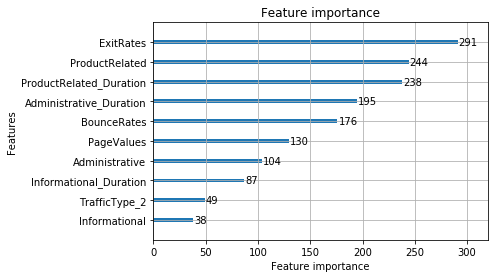

In [73]:
#feature importance for the best tree based model
%matplotlib inline
lgb.plot_importance(clf_encoded,max_num_features=10)

## Conclusion

The top 10 features affecting the buying intentions were identified. These features can be further isolated depending upon the applications. For eg. Exit would be a good measure of how well personalized webpages are working for users. A simple A/B test can be carried out with and without personalization and exit rates as well as other features can be monitored. Change in these features would indicate a change in buying intent and tell us if the test was succesfull. 